In [1]:
!pip3 install --quiet pandas-market-calendars
import os
import pandas as pd
import numpy as np
import datetime as dt
import pandas_market_calendars as mcal

In [2]:
# Define date ranges
train_start_date = '2014-01-01'
train_end_date = '2015-07-31'
val_start_date = '2015-08-01'
val_end_date = '2015-09-30'
test_start_date = '2015-10-01'
test_end_date = '2016-01-01'

In [12]:
# Construct Dummy Data
np.random.seed(0)
index = pd.date_range(start=train_start_date, end=train_end_date, freq='D')
df_orders = pd.DataFrame(index=index, columns=['AAPL', 'GOOG'])
df_orders['AAPL'] = np.random.choice([-1, 1],  size=len(df_orders))
df_orders['GOOG'] = np.random.choice([-1, 1], size=len(df_orders))
#df_orders['AAPL'] = 1
#df_orders['GOOG'] = 0
print(df_orders)

            AAPL  GOOG
2014-01-01    -1     1
2014-01-02     1     1
2014-01-03     1    -1
2014-01-04    -1    -1
2014-01-05     1     1
...          ...   ...
2015-07-27     1     1
2015-07-28    -1    -1
2015-07-29    -1    -1
2015-07-30     1     1
2015-07-31     1    -1

[577 rows x 2 columns]


In [13]:
# Get data for specific stock
path = 'stocknet-dataset-master/price/raw'
def get_data(symbols, dates):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index=dates)
    
    """Iterate over each symbol"""
    for symbol in symbols:
        """Import new data"""
        df_temp = pd.read_csv(os.path.join(path, symbol+'.csv'), index_col='Date',
                parse_dates=True, usecols=['Date', 'Adj Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Adj Close': symbol})
        df = df.join(df_temp)
    return df

In [14]:
print(get_data(['AAPL'], pd.date_range(start='1/1/1993', end='today')).dropna())

                  AAPL
2012-09-04   87.121140
2012-09-05   86.509338
2012-09-06   87.288956
2012-09-07   87.827171
2012-09-10   85.542564
...                ...
2017-08-28  161.470001
2017-08-29  162.910004
2017-08-30  163.350006
2017-08-31  164.000000
2017-09-01  164.050003

[1258 rows x 1 columns]


In [15]:
cache = {}
calendar = mcal.get_calendar('NYSE')
def next_trading_day(start_day=None, SAFE_DELTA = 5):
        """Returns the next/previous trading date separated by a certain number of 
        trading days.
        """
        if start_day is None:
            start_day = datetime.datetime.utcnow().date()
        if start_day in cache:
            return cache[start_day]
        start = pd.to_datetime(start_day)
        end = start + np.timedelta64(SAFE_DELTA, 'D')
        business_days = calendar.valid_days(start_date=start, end_date=end)
        next_day = business_days[1].date()
        next_day = next_day.strftime("%Y-%m-%d")
        cache[start_day] = next_day
        return next_day

In [16]:
# Calculate value change of portfolio assuming the order file and equal cash allocation
def compute_portvals(df_orders, start_val = 100, commission=0, impact=0):
    # prep variables and date range
    df_orders.sort_index(inplace=True)
    start_date = df_orders.index[0]
    end_date = next_trading_day(df_orders.index[-1])
    symbols = list(set(df_orders.columns.values))
    
    # get price data
    df_prices = get_data(symbols, pd.date_range(start_date, end_date, freq='D')).dropna()
    df_prices = df_prices[symbols]
    df_price_change = df_prices.pct_change()
    df_price_change.iloc[0] = 0
    
    # calculate cumulative holdings
    df_holdings = pd.DataFrame(index=df_prices.index, columns=df_prices.columns.values)
    df_holdings.iloc[0] = 0
    df_holdings.update(df_orders)
    df_holdings = df_holdings.ffill()
    df_port_change = pd.DataFrame(columns=['portfolio'], index=df_price_change.index)
    for index, row in df_holdings.iterrows():
        vals = []
        for col in df_holdings.columns.values:
            if row[col] == 1:
                vals.append(df_price_change.loc[index, col])
            
        if len(vals) == 0:
            vals.append(0)
        df_port_change.loc[index] = sum(vals)/len(vals) + 1
    df_values = df_port_change.cumprod() * start_val
    
    # equal dollar allocation portfolio
    return df_values

           portfolio
2014-01-02       100
2014-01-03   97.8034
2014-01-06   98.3367
2014-01-07   97.6335
2014-01-08   98.0442
...              ...
2015-07-28   114.748
2015-07-29   114.748
2015-07-30   114.519
2015-07-31   113.517
2015-08-03   110.841

[399 rows x 1 columns]


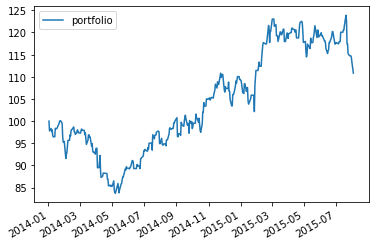

In [17]:
portvals = compute_portvals(df_orders)#[pd.to_datetime('2014-01-02')]
print(portvals)
portvals.plot()

In [9]:
def sharpe(portvals, risk_free_rate=0):
    daily_returns = portvals.pct_change().dropna()
    avg_return = np.mean(daily_returns)
    risk = np.std(daily_returns)
    return (np.sqrt(252) * avg_return - risk_free_rate) / risk

In [10]:
print(sharpe(portvals))

portfolio    0.445192
dtype: float64


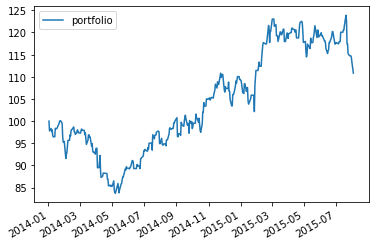

In [11]:
portvals.plot()